# This notebook creates a pandas dataframe containing a random undersample of non-burned data points from the Portugal wildfire dataset located in Mesogeos datacube.

## The notebook is divided into 4 parts: 
## 1. pre-processing Mesogeos datacube to extract Portugal only.
## 2. creating a Pandas dataframe where each row is a vector corresponding to a point where fire didn't happen in Portugal in a given x, y, and time followed by a list of meteorological and intrinsic features.
## 3. extracting the climatic features, calculated as the average over the entire period of the dataset, for the areas where wildfires have happended in Portugal.
## 4. performing data imputation to estimate missing values in the Portugal wildfire dataset.

## The data is undersampled to have a balanced training and testing dataset for wildfire classifcation algorithm
## The source of the data is Mesogeos datacube.
## Datacube Source: https://github.com/Orion-AI-Lab/mesogeos/tree/main
## Portugal Shapefile Source: https://geodata.lib.utexas.edu/catalog/stanford-tq087tk3612
## Created by Aser Atawya for wildfire clustering project as part of Beculer Lab at University of Lausanne







# Imports and Installing dependencies (dependencies list is not minimal)


In [ ]:
!pip install zarr
!pip install sklearn-som
!pip install minisom
!pip install rasterio
!pip install rioxarray
!pip install geojson
!pip install netCDF4

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler, scale
import numpy as np
from osgeo import gdal
import rasterio as rio
import geopandas
import rasterio.features
import rioxarray
import geojson
import pandas as pd
import scipy.stats as stats
import random
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from shapely.geometry import mapping
from shapely.ops import cascaded_union
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# First: Accessing Data and Clipping Portugal

In [ ]:
# to reproduce:
# 1. Add the dataset's https://drive.google.com/drive/folders/1aRXQXVvw6hz0eYgtJDoixjPQO-_bRKz9 to your shortcuts in Google Drive. 
# 2. Then you can use the shortcut path to open the dataset.
ds = xr.open_zarr('/content/drive/MyDrive/mesogeos/mesogeos_cube.zarr/', decode_coords=all) # change path to point to your dataset shortcut in your Google Drive
# The official dataset exploration notebook is available at https://colab.research.google.com/drive/1CJKl4ojtHdoDGC54hLwuqTHOMDvVlgn5

In [ ]:
ds

<xarray.Dataset>
Dimensions:               (y: 1752, x: 4714, time: 6026)
Coordinates:
  * time                  (time) datetime64[ns] 2006-04-01 ... 2022-09-29
  * x                     (x) float64 -10.72 -10.71 -10.7 ... 36.72 36.73 36.74
  * y                     (y) float64 47.7 47.69 47.68 ... 30.09 30.08 30.07
Data variables: (12/30)
    aspect                (y, x) float32 dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    burned_areas          (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    curvature             (y, x) float32 dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    d2m                   (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    dem                   (y, x) float32 dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    ignition_points       (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    ...                    ...
    spatial_ref           int64 ...
    ssrd                  (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    t2m                   (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    tp                    (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    wind_direction        (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    wind_speed            (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>

In [ ]:
# slice a rectangle including Portugal from original dataset to speeden masking
# Those points represent the eastmost, westmost, northmost, and southmost points in Portugal mainland
ds_portugal = ds.sel(x=slice(-9.50,-6.20), y=slice( 42.16, 36.96))

In [ ]:
ds_portugal

<xarray.Dataset>
Dimensions:               (y: 516, x: 327, time: 6026)
Coordinates:
  * time                  (time) datetime64[ns] 2006-04-01 ... 2022-09-29
  * x                     (x) float64 -9.491 -9.481 -9.471 ... -6.218 -6.208
  * y                     (y) float64 42.15 42.14 42.13 ... 36.99 36.98 36.97
Data variables: (12/30)
    aspect                (y, x) float32 dask.array<chunksize=(516, 327), meta=np.ndarray>
    burned_areas          (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    curvature             (y, x) float32 dask.array<chunksize=(516, 327), meta=np.ndarray>
    d2m                   (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    dem                   (y, x) float32 dask.array<chunksize=(516, 327), meta=np.ndarray>
    ignition_points       (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    ...                    ...
    spatial_ref           int64 ...
    ssrd                  (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    t2m                   (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    tp                    (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    wind_direction        (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    wind_speed            (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>

In [ ]:
portugal = geopandas.read_file('/content/drive/MyDrive/data/tq087tk3612.shp', crs="epsg:4326")
# The source of the shape file is https://geodata.lib.utexas.edu/catalog/stanford-tq087tk3612
# The path used here is local. Please change the path to the location of the shapefile on your system.

In [ ]:
portugal

,id_0,iso,name_engli,name_iso,name_fao,name_local,name_obsol,name_varia,name_nonla,name_frenc,name_spani,name_russi,name_arabi,name_chine,waspartof,contains,sovereign,iso2,www,fips,ison,validfr,validto,pop2000,sqkm,popsqkm,unregion1,unregion2,developing,cis,transition,oecd,wbregion,wbincome,wbdebt,wbother,ceeac,cemac,ceplg,comesa,eac,ecowas,igad,ioc,mru,sacu,uemoa,uma,palop,parta,cacm,eurasec,agadir,saarc,asean,nafta,gcc,csn,caricom,eu,can,acp,landlocked,aosis,sids,islands,ldc,geometry
0,182.0,PRT,Portugal,PORTUGAL,Portugal,Portugal,NaN,Azores|Madeira,NaN,Portugal,Portugal,??????????,????????,???,NaN,NaN,Portugal,PT,NaN,PO,620.0,Unknown,Present,10015505.0,92098.273,108.748022,Southern Europe,Europe,2.0,0.0,0.0,1.0,NaN,High income: OECD,Debt not classified,EMU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-16.05835 30.03020, -16.05837 ..."


In [ ]:
ds_portugal.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
ds_portugal.rio.write_crs("epsg:4326", inplace=True)

clipped = ds_portugal.rio.clip(portugal.geometry.apply(mapping), portugal.crs, drop=True, from_disk =True)

In [ ]:
np.count_nonzero(np.isnan(clipped['roads_distance'].values))
# This is the number of 1*1 km squares there were filtered out and converted to NaN

76456

In [ ]:
np.count_nonzero(~np.isnan(clipped['roads_distance'].values))
# This is the number of remaining 1*1 km squares

91949

### While we have 76456 squares that are Nans, we can't remove them because the datacube is structred as X,Y coordinates that represent 2D array i.e. rectangle.

# Visualizations of the clipped datacube

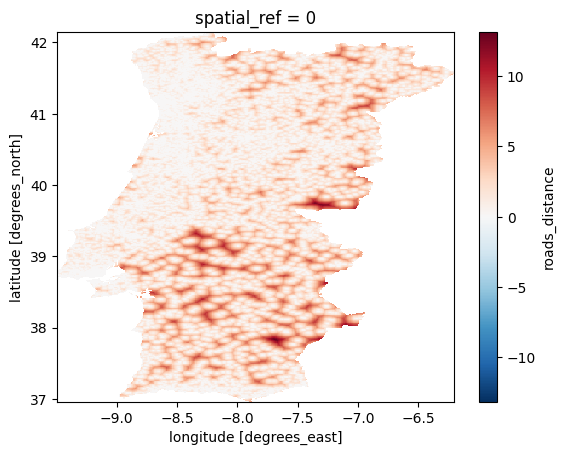

In [ ]:
clipped.roads_distance.plot()

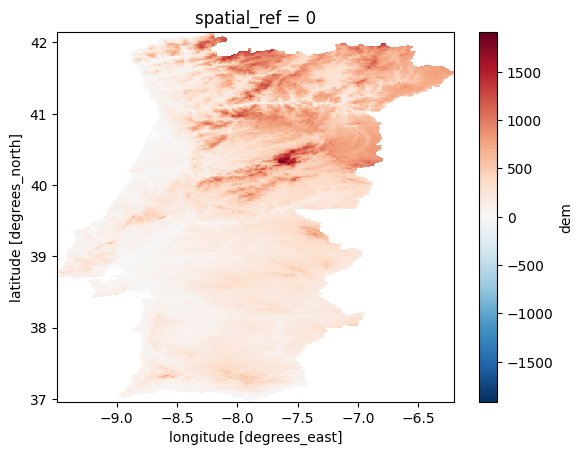

In [ ]:
clipped.dem.plot()

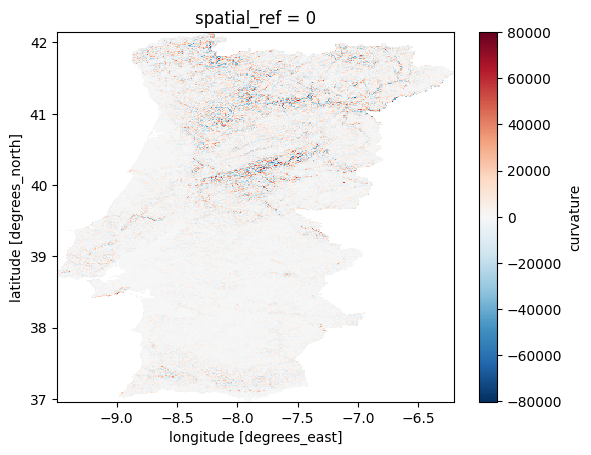

In [ ]:
clipped.curvature.plot()

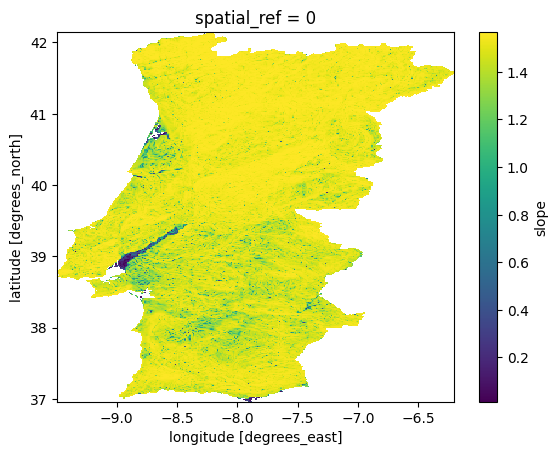

In [ ]:
clipped.slope.plot()

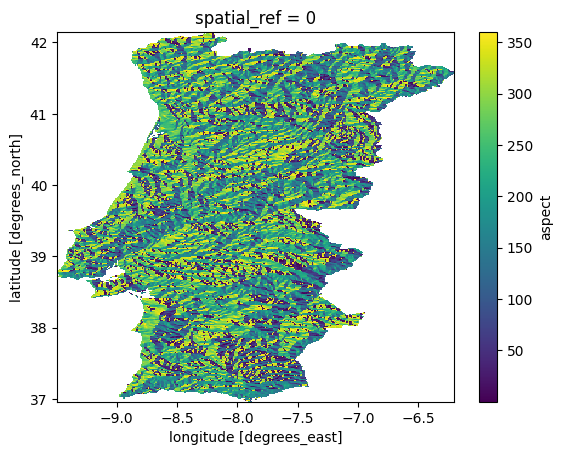

In [ ]:
clipped.aspect.plot()

# Second: Creating a Pandas dataframe where each row is a vector corresponding to a point where fire didn't happen in Portugal in a given x, y, and time followed by a list of meteorological and intrinsic features.

In [ ]:
# function to loop over days in a given data range
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [ ]:
# extract variable names of the data cube and omit spatial_ref since it's empty
colnames = []
for var in clipped.variables:
  if var == 'spatial_ref':
      pass
  else:
    colnames.append(var)
# order the variables such that x, y, and time are in the beginnig
colnames[2], colnames[3] = colnames[3], colnames[2]

In [ ]:
lst = []
vec_lst = []
# for the start and end data, extracting one year takes roughly 1 and half hour using Google Collab.
# I recommend extracting each year separately, and then concating all the resulting pandas
start_date = date(2006, 4, 1)
end_date = date(2022, 9, 29)

for single_date in daterange(start_date, end_date):
  day = single_date.strftime("%Y-%m-%d")
  lst = []
  for var in colnames:
    # these variables are time-indexed
    if var not in ['aspect', 'curvature', 'dem', 'roads_distance', 'slope']:
      lst.append(np.asarray(clipped.sel(time = day)[var]))
    # these variables are not time-indexed (aspect, curvature, etc.)
    else:
      lst.append(np.asarray(clipped[var]))

  # create vector(list) for each point in x, y, and t
  for y in range(515): #515 values for y coordinate
    for x in range(327): #327 values for x coordinate
      vector = []
      # random under-sampling
      if random.randint(1,15000) % 15000 != 0:
        continue
      # lst[4][y][x] == 0 ensures a fire didn't happen in that point at given x, y, t
      #  ~np.isnan(lst[23][y][x]) ensures this point is inside Portugal
      if ~np.isnan(lst[23][y][x]) and lst[4][y][x] == 0:
        # x coordinate
        vector.append(lst[0][x])
        # y coordinate
        vector.append(lst[1][y])
        # time t
        vector.append(day)
        for i in range(3, 32):
          # add all the values
          vector.append(lst[i][y][x])
        vec_lst.append(vector)

In [ ]:
years = pd.DataFrame(data = vec_lst, columns = colnames)

In [ ]:
# Edit the path to be to your desired path on your Google drive
# Recommend saving data at this point to avoid re-running the time-consuming code above if runtime session was lost
years.to_csv('/content/drive/MyDrive/data/non_burned/without_annual_1.csv')

In [ ]:
# Those variables are updated annually, and the 1st Jan of each year has the values of the year
cols = ['lc_agriculture', 'lc_forest', 'lc_grassland', 'lc_settlement', 'lc_shrubland', 'lc_sparse_vegetation', 'lc_water_bodies', 'lc_wetland', 'population']

In [ ]:
# add multiple date-related features to the dataset, such as year, month, day, and day of the year
for index1, row1 in years.iterrows():
    # extract year, month, and day
    year = int(years['time'].values[index1][0:4])
    month = int(years['time'].values[index1][5:7])
    day = int(years['time'].values[index1][8:10])
    day_of_the_year = date(year, month, day).timetuple().tm_yday
    years.at[index1, 'year'] = year
    years.at[index1, 'month'] = month
    years.at[index1, 'day'] = day
    years.at[index1, 'day_of_the_year'] = day_of_the_year
    # winter days will be close to 1 and summer days will be close to -1
    years.at[index1, 'cos_day_of_the_year'] = math.cos(day_of_the_year * 2 * math.pi/365)
    years.at[index1, 'sin_day_of_the_year'] = math.sin(day_of_the_year * 2 * math.pi/365)

years['year'] = years['year'].astype('int')
years['month'] = years['month'].astype('int')
years['day'] = years['day'].astype('int')
years['day_of_the_year'] = years['day_of_the_year'].astype('int')

In [ ]:
# handles the variables updated annually
for index1, row1 in years.iterrows():
  for var in cols:
    years.at[index1, var] = (np.asarray(clipped.sel(x = row1['x'], y = row1['y'], method='nearest', time = date(row1['year'], 1, 1).strftime("%Y-%m-%d"))[var]))

In [ ]:
# Edit the path to be to your desired path on your Google drive
# Recommend saving data at this point to avoid re-running the time-consuming code above if runtime session was lost
years.to_csv('/content/drive/MyDrive/data/non_burned/with_annual.csv')

In [ ]:
# create 2 columns with values int instead of float for x and y to make it easier for comparisons and data manuiplation for feature engineerng
years['x_int'] = round(years['x'], 3) * 100
years['y_int'] = round(years['y'], 3) * 100
years['x_int'] = years['x_int'].astype('int')
years['y_int'] = years['y_int'].astype('int')

In [ ]:
years = years.sort_values(by=['x_int', 'y_int'])
years = years.reset_index()
years = years.drop(columns=[ 'index'])
years

,x,y,time,aspect,burned_areas,curvature,d2m,dem,ignition_points,lai,lc_agriculture,lc_forest,lc_grassland,lc_settlement,lc_shrubland,lc_sparse_vegetation,lc_water_bodies,lc_wetland,lst_day,lst_night,ndvi,population,rh,roads_distance,slope,smi,sp,ssrd,t2m,tp,wind_direction,wind_speed,year,month,day,day_of_the_year,cos_day_of_the_year,sin_day_of_the_year,x_int,y_int
0,-9.490683,38.768062,2006-10-13,242.346909,0.0,25867.835938,NaN,174.015976,0.0,NaN,0.153392,0.248340,0.0,0.000000,0.021067,0.0,0.397186,0.180015,297.459991,NaN,0.6495,1.598184,NaN,0.000,1.560071,0.79834,NaN,NaN,NaN,NaN,NaN,NaN,2006,10,13,286,0.209315,-0.977848,-949,3876
1,-9.460476,38.707648,2007-08-21,203.676575,0.0,4183.317383,NaN,50.300114,0.0,0.9,0.685615,0.221857,0.0,0.092528,0.000000,0.0,0.000000,0.000000,295.320007,288.739990,0.4828,127.543106,NaN,0.371,1.536229,0.27312,NaN,NaN,NaN,NaN,NaN,NaN,2007,8,21,233,-0.645348,-0.763889,-946,3870
2,-9.460476,38.798269,2006-11-28,356.892487,0.0,-2708.698975,NaN,140.850327,0.0,1.1,0.980001,0.010364,0.0,0.009636,0.000000,0.0,0.000000,0.000000,288.000000,282.880005,0.6544,378.000793,NaN,0.000,1.558537,0.96884,NaN,NaN,NaN,NaN,NaN,NaN,2006,11,28,332,0.842942,-0.538005,-946,3879
3,-9.440338,38.727786,2008-04-09,189.512360,0.0,4144.878906,NaN,98.617561,0.0,0.7,0.293637,0.036163,0.0,0.670200,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.5359,794.456116,NaN,0.000,1.506740,0.57735,NaN,NaN,NaN,NaN,NaN,NaN,2008,4,9,100,-0.150055,0.988678,-944,3872
4,-9.440338,38.848614,2007-09-30,312.312469,0.0,5228.369141,NaN,128.883530,0.0,0.5,0.591861,0.074911,0.0,0.333228,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.4299,860.879028,NaN,0.000,1.481594,0.30975,NaN,NaN,NaN,NaN,193.726532,NaN,2007,9,30,273,-0.012910,-0.999917,-944,3884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6718,-6.268612,41.597443,2006-05-08,238.532104,0.0,-464.849854,279.945679,780.328247,0.0,2.6,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,294.399994,NaN,0.6389,0.000000,0.328402,0.718,1.507246,0.79129,93140.625000,14155806.0,292.517914,2.161669e-05,46.924469,2.548560,2006,5,8,128,-0.591261,0.806480,-626,4159
6719,-6.248474,41.607512,2007-10-18,68.276291,0.0,257.910156,280.179260,801.746521,0.0,0.7,0.684449,0.315551,0.0,0.000000,0.000000,0.0,0.000000,0.000000,NaN,280.040009,0.3970,0.000000,0.424239,0.416,1.515866,0.47349,93736.859375,7793179.5,291.657318,1.511433e-07,50.105179,2.542588,2007,10,18,291,0.292600,-0.956235,-624,4160
6720,-6.228336,41.597443,2006-11-07,51.542427,0.0,-6702.813477,283.449402,760.159363,0.0,0.6,0.283500,0.534263,0.0,0.000000,0.182237,0.0,0.000000,0.000000,NaN,NaN,0.5829,0.000000,0.694872,1.469,1.512671,0.87610,93818.031250,3820787.0,288.605347,8.728625e-04,60.105942,4.174960,2006,11,7,311,0.598181,-0.801361,-622,4159
6721,-6.218267,41.547098,2008-03-04,106.000244,0.0,-7686.932617,269.680695,656.406311,0.0,0.3,0.221780,0.177264,0.0,0.000000,0.600956,0.0,0.000000,0.000000,286.179993,271.380005,0.5734,0.022890,0.352741,4.148,1.541004,0.86734,94393.015625,8472194.0,282.367981,7.450581e-09,33.681839,5.940156,2008,3,4,64,0.452072,0.891981,-621,4154


In [ ]:
# add a new feature to the dataset, which is the number of times a given square was burned in the timeframe of the data
years['repetitions'] = 0
for index1, row1 in years.iterrows():
    x1 = row1['x_int']
    y1 = row1['y_int']
    repeat = 0
    if row1['repetitions'] > 0:
        continue
    for index2 in range(index1, len(years)):
        x2 = years.loc[index2,'x_int']
        y2 = years.loc[index2, 'y_int']
        repetitions =  years.loc[index2, 'repetitions']
        if repetitions > 0:
            years.at[index1, 'repetitions'] = repetitions
            break
        elif x1 == x2 and y1 == y2:
            repeat += 1
        else:
            for i in range(index1, index2):
                years.at[i, 'repetitions'] = repeat
            break
# handle edge case of last element in row
if years.at[len(years) - 1, 'repetitions'] == 0:
    years.at[len(years) - 1, 'repetitions'] = 1

In [ ]:
# Edit the path to be to your desired path on your Google drive
# Recommend saving data at this point to avoid re-running the time-consuming code above if runtime session was lost
years.to_csv('/content/drive/MyDrive/data/non_burned/with_extra_features.csv')

# Third: Extracting the climatic features, calculated as the average over the entire period of the dataset, for the areas where wildfires have happended in Portugal.

In [ ]:
# finds the index coressponding to x an y cooridnate
x_arr = np.asarray(clipped['x'])
y_arr = np.asarray(clipped['y'])

def findy(y):
  return np.where(np.isclose(y_arr, y, 0.0001))[0][0]

def findx(x):
  return np.where(np.isclose(x_arr, x, 0.0001))[0][0]

In [ ]:
# calculates mean over time
clipped_mean = clipped.mean(dim='time', skipna=True)
clipped_mean

In [ ]:
d2m_mean = np.asarray(clipped_mean['d2m'])
wind_speed_mean = np.asarray(clipped_mean['wind_speed'])
wind_direction_mean = np.asarray(clipped_mean['wind_direction'])
lst_night_mean = np.asarray(clipped_mean['lst_night'])
t2m_mean = np.asarray(clipped_mean['t2m'])
tp_mean = np.asarray(clipped_mean['tp'])
sp_mean = np.asarray(clipped_mean['sp'])
ssrd_mean = np.asarray(clipped_mean['ssrd'])
rh_mean = np.asarray(clipped_mean['rh'])
lst_day_mean = np.asarray(clipped_mean['lst_day'])

In [ ]:
#placeholder
years['d2m_mean'] = 0
years['wind_speed_mean'] = 0
years['wind_direction_mean'] = 0
years['lst_night_mean'] = 0
years['t2m_mean'] = 0
years['tp_mean'] = 0
years['sp_mean'] = 0
years['ssrd_meean'] = 0
years['rh_mean'] = 0
years['lst_day_mean'] = 0

In [ ]:
for index1, row1 in years.iterrows():
  years.at[index1, 'd2m_mean'] = d2m_mean[findy(row1['y'])][findx(row1['x'])]
  years.at[index1, 'wind_speed_mean'] = wind_speed_mean[findy(row1['y'])][findx(row1['x'])]
  years.at[index1, 'wind_direction_mean'] = wind_direction_mean[findy(row1['y'])][findx(row1['x'])]
  years.at[index1, 'lst_night_mean'] = lst_night_mean[findy(row1['y'])][findx(row1['x'])]
  years.at[index1, 't2m_mean'] = t2m_mean[findy(row1['y'])][findx(row1['x'])]
  years.at[index1, 'tp_mean'] = tp_mean[findy(row1['y'])][findx(row1['x'])]
  years.at[index1, 'sp_mean'] = sp_mean[findy(row1['y'])][findx(row1['x'])]
  years.at[index1, 'ssrd_mean'] = ssrd_mean[findy(row1['y'])][findx(row1['x'])]
  years.at[index1, 'rh_mean'] = rh_mean[findy(row1['y'])][findx(row1['x'])]
  years.at[index1, 'lst_day_mean'] = lst_day_mean[findy(row1['y'])][findx(row1['x'])]

In [ ]:
# Edit the path to be to your desired path on your Google drive
# Recommend saving data at this point to avoid re-running the time-consuming code above if runtime session was lost
years.to_csv('/content/drive/MyDrive/data/non_burned/with_climate.csv')

# Fourth Data imputation to estimate missing values in the Portugal non-burned dataset

In [ ]:
# print number of missing values for each column for data exploration
cols = years.columns
for val in cols:
    print(val, years[val].isna().sum())

In [ ]:
# adds cosine and sin for month 
years_2 = years.copy(deep=True)
for index1, row1, in years_2.iterrows():
    month =  row1['month']
    years_2.at[index1, 'cos_month'] = math.cos(month * 2 * math.pi/12)
    years_2.at[index1, 'sin_month'] = math.sin(month * 2 * math.pi/12)

In [ ]:
# drop irrelevat columns before doing data imputation
cols = [ 'time', 'repetitions', 'day_of_the_year', 'x_int', 'y_int', 'day', 'month', 'burned_areas', 'roads_distance']
years_2 = years_2.drop(columns=cols)
imputer = IterativeImputer(random_state=1, imputation_order = 'ascending')
imputed = imputer.fit_transform(years_2)
years_2 = pd.DataFrame(imputed, columns=years_2.columns)

# appending irrelevant columns back
for val in cols:
    years_2[val] = years[val]
    

years_2

In [ ]:
# Edit the path to be to your desired path on your Google drive
# Recommend saving data at this point to save the pandas dataframe and avoid re-running the time-consuming code
years_2.to_csv('/content/drive/MyDrive/data/non_burned/data_completed.csv')